Notebook inspired from: https://github.com/JudeWells/keras_anomaly_detection

In [385]:
import os
from os import listdir,makedirs
from os.path import isfile,join
import cv2
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, UpSampling2D
import matplotlib.pyplot as plt
import numpy as np
from keras.preprocessing.image import ImageDataGenerator
from sklearn.neighbors import KernelDensity
import sys
np.set_printoptions(threshold=sys.maxsize)

# Data preprocessing
### Convert images to grayscale (optional)

In [ ]:
path = 'toothbrush/test/defective' # Source Folder
dstpath = 'toothbrush_grayscale/test/defective' # Destination Folder
try:
    makedirs(dstpath)
except:
    print ("Directory already exist, images will be written in same folder")

files = list(filter(lambda f: isfile(join(path,f)), listdir(path)))
for image in files:
    try:
        img = cv2.imread(os.path.join(path,image))
        gray = cv2.cvtColor(img,cv2.COLOR_RGB2GRAY)
        dstPath = join(dstpath,image)
        cv2.imwrite(dstPath,gray)
    except:
        print ("{} is not converted".format(image))

### Create ImageDataGenerators
Create generators for training (only normal images), validation (only normal images), anomaly (only outlier images) and testing (normal and outlier images). The generators include downsampling and normalization of the images.

In [387]:
image_size = 128
batch_size = 10
datagen = ImageDataGenerator(rescale=1./255)
train_generator = datagen.flow_from_directory(
    'toothbrush_grayscale/train/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

validation_generator = datagen.flow_from_directory(
    'toothbrush_grayscale/test/0_good/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

anomaly_generator = datagen.flow_from_directory(
    'toothbrush_grayscale/test/1_defective/',
    target_size=(image_size, image_size),
    batch_size=batch_size,
    class_mode='input'
    )

test_generator = datagen.flow_from_directory(
    'toothbrush_grayscale/test/',
    target_size=(image_size, image_size),
    batch_size=1,
    class_mode='binary'
    )

Found 60 images belonging to 1 classes.
Found 12 images belonging to 1 classes.
Found 30 images belonging to 1 classes.
Found 42 images belonging to 2 classes.


In [388]:
test_generator.class_indices

{'0_good': 0, '1_defective': 1}

# Model Definition and Training
### Convolutional Autoencoder Definition

In [178]:
# Input shape must be the same size as the images that will be fed into it by the generators
# The output layer must be the same dimensions as the target (which is the original image)
model = Sequential()

# -------------------------------------------------------------------

# ENCODER
model.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(image_size, image_size, 3)))
model.add(MaxPooling2D(pool_size=(4,4), padding='same')) # using pool_size (2,2) makes the layer 2x smaller in height and width

model.add(Conv2D(64,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

model.add(Conv2D(128,(3, 3),activation='relu',  padding='same'))
model.add(MaxPooling2D(pool_size=(2,2), padding='same'))

# -------------------------------------------------------------------

# DECODER
model.add(Conv2D(128,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(64,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((2, 2)))

model.add(Conv2D(32,(3, 3),activation='relu',  padding='same'))
model.add(UpSampling2D((4, 4)))

model.add(Conv2D(3,(3, 3), activation='sigmoid', padding='same'))

# -------------------------------------------------------------------

model.summary()

# Compile the model
model.compile(optimizer='adadelta', loss='mean_squared_error')

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_76 (Conv2D)           (None, 128, 128, 32)      896       
_________________________________________________________________
max_pooling2d_40 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_77 (Conv2D)           (None, 32, 32, 64)        18496     
_________________________________________________________________
max_pooling2d_41 (MaxPooling (None, 16, 16, 64)        0         
_________________________________________________________________
conv2d_78 (Conv2D)           (None, 16, 16, 128)       73856     
_________________________________________________________________
max_pooling2d_42 (MaxPooling (None, 8, 8, 128)         0         
_________________________________________________________________
conv2d_79 (Conv2D)           (None, 8, 8, 128)       

### Model training

In [ ]:
# Training the model
es = keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=30) # Early stopping (stops training when validation doesn't improve for {patience} epochs)
model_filepath = 'models/toothbrush_model1.keras'
save_best = keras.callbacks.ModelCheckpoint(model_filepath, monitor='val_loss', save_best_only=True, mode='min') # Saves the best version of the model to disk (as measured on the validation data set)
model.fit_generator(
        train_generator,
        epochs=600,
        validation_data=validation_generator,
        shuffle = True,
        callbacks=[es, save_best])

# Model Evaluation
If you have already trained a model, you can start from here testing and evaluating the model

In [180]:
# Training continues after improvement stops for the number of epochs equivalent to the 'patience' hyper-parameter
# To get back the model that performed best on the validation set we load the checkpointed model from disk:
model = keras.models.load_model(model_filepath)

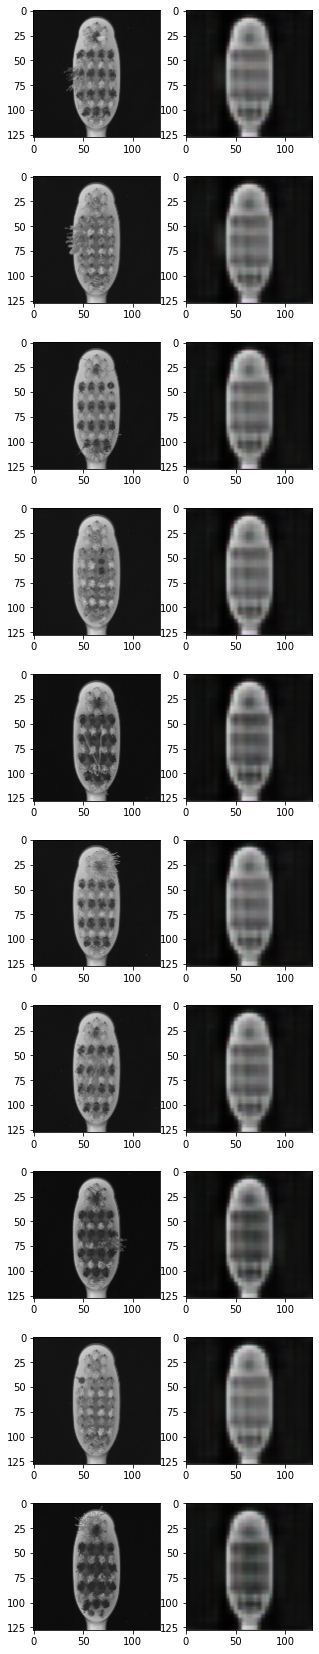

In [395]:
no_of_samples = 10
_, axs = plt.subplots(no_of_samples, 2, figsize=(5, 30))
axs = axs.flatten()
imgs = []      
for i in range(no_of_samples//anomaly_generator.batch_size+1):
    img, label = anomaly_generator.next()
    reconstruction = model.predict(img)
    for j in range(anomaly_generator.batch_size):
        r = reconstruction[j]
        imgs.append(img[j])
        imgs.append(r)
for img, ax in zip(imgs, axs):
    ax.imshow(img)
plt.show()

## Choosing thresholds
### Reconstruction error 

In [ ]:
def get_reconstruction_errors(generator):
    reconstruction_errors = []
    for i in range(generator.samples):
        img, _ = generator.next()
        reconstruction = model.predict([img])
        reconstruction_error = model.evaluate([reconstruction], [img], batch_size=1)
        print(reconstruction_error)
        reconstruction_errors.append(reconstruction_error)
    return reconstruction_errors

# Reconstruction errors of the different generators
train_reconstruction_error = get_reconstruction_errors(train_generator)
val_reconstruction_error = get_reconstruction_errors(validation_generator)

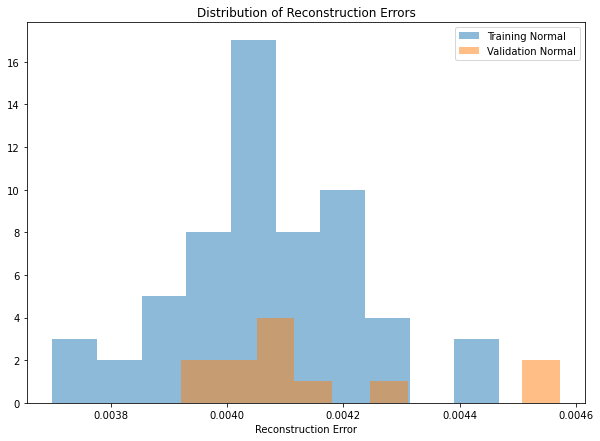

In [384]:
# Plotting the reconstruction error distributions of the training and validation data to determine thresholds
plt.figure(figsize = (10,7))
plt.title('Distribution of Reconstruction Errors')
plt.hist(train_reconstruction_error, alpha=0.5, label='Training Normal')
plt.hist(val_reconstruction_error, alpha=0.5, label='Validation Normal')
plt.legend(loc='upper right')
plt.xlabel('Reconstruction Error')

plt.show()

### Kernel density estimation 

In [ ]:
# We build a replica of the first half of the auto-encoder (the encoder only)
# This network takes a an image which is 128x128x3 and compresses it down to a 8x8x8 tensor
encoder_replica = Sequential()
encoder_replica.add(Conv2D(32, (3, 3), padding='same',activation='relu', input_shape=(image_size, image_size, 3), weights=model.layers[0].get_weights()) )
encoder_replica.add(MaxPooling2D(pool_size=(4,4), padding='same'))
encoder_replica.add(Conv2D(64,(3, 3),activation='relu',  padding='same', weights=model.layers[2].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.add(Conv2D(128,(3, 3),activation='relu',  padding='same', weights=model.layers[4].get_weights()))
encoder_replica.add(MaxPooling2D(pool_size=(2,2), padding='same'))
encoder_replica.summary()

In [345]:
# Creating encoded (compressed versions of the training and validation images) and getting their density
# The SKLearn kernel density function only works with 1D arrays so we need to flatten the tensors created by the encoder
encoded_images = encoder_replica.predict_generator(train_generator)
encoded_images_flat = [img.flatten() for img in encoded_images]

validation_encoded = encoder_replica.predict_generator(validation_generator)
val_enc_flat = [img.flatten() for img in validation_encoded]

[5652.47657229 5652.4765728  5652.47657014 5652.47681481 5652.49500586
 5652.47657009 5652.47657041 5652.47705646 5652.4770299  5652.47942996
 5652.47657021 5652.47657183 5652.47664961 5652.47711764 5652.47774584
 5652.47687181 5652.47923009 5652.47657021 5652.4766641  5652.47784627
 5652.48576727 5652.47709322 5652.47840391 5652.47657059 5652.47657032
 5652.480476   5652.47657015 5652.48389935 5652.47661708 5652.47657366
 5652.47760523 5652.47658746 5652.47657757 5652.47657564 5652.47657982
 5652.47661671 5652.47673762 5652.47658475 5652.48370257 5652.47657351
 5652.47657221 5652.47662173 5652.47657012 5652.476571   5652.47657189
 5652.47784019 5652.4768369  5652.47811309 5652.47657109 5652.47657385
 5652.47657014 5652.47657344 5652.47657362 5652.48022437 5652.47657013
 5652.49390721 5652.47799163 5652.47657012 5652.47776053 5652.47690886]


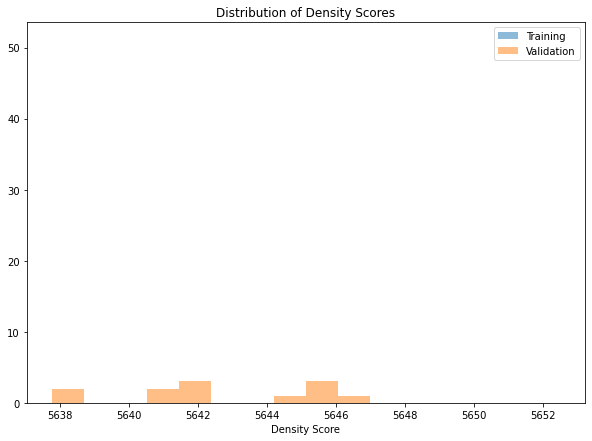

In [346]:
# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)
print(training_density_scores)

# Plotting the density distributions of the training and validation data
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, alpha=0.5, label='Training')
plt.hist(validation_density_scores, alpha=0.5, label='Validation')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()

Set threshold for kernel density to 5630 and for reconstruction error to 0.005.
### Evaluating model

In [389]:
def check_anomaly(img):
    density_threshold = 5630 # Chosen based on the distribution of the density scores of of non-outlier data (training and validation data)
    reconstruction_error_threshold = 0.005 # Chosen based on the distribution of reconstruction errors of non-outlier data (training and validation data)
    encoded_img = encoder_replica.predict([img]) # Create a compressed version of the image using the encoder
    encoded_img = [np.reshape(img, (8192)) for img in encoded_img] # Flatten the compressed image
    density = kde.score_samples(encoded_img)[0] # get a density score for the new image
    print(f'density: {density}')
    reconstruction = model.predict([img])
    reconstruction_error = model.evaluate([reconstruction], [img], batch_size=1)
    print(f'reconstruction_error: {reconstruction_error}')
    if density < density_threshold or reconstruction_error > reconstruction_error_threshold:
        return 1
    else:
        return 0

In [ ]:
from sklearn.metrics import f1_score

y_true = []
y_pred = []
for i in range(test_generator.samples):
    img, label = test_generator.next()
    y_true.append(label)
    y_pred.append(check_anomaly(img))
f1_score(y_true, y_pred)

In [391]:
f1_score(y_true, y_pred)

0.846153846153846

## Verifying distribution of reconstruction error of anomalous data
Ideally the reconstruction error of anomalous data should be higher then those of normal data and above the chosen threshold of 0.005

In [182]:
# We want the difference the difference in error between the validation (normal) images and anomalous images to be as high as possible
print(f"Error on validation set:{model.evaluate_generator(validation_generator)}, error on anomaly set:{model.evaluate_generator(anomaly_generator)}")

Error on validation set:0.0031974585726857185, error on anomaly set:0.0037394599057734013


In [ ]:
anom_reconstruction_error = get_reconstruction_errors(anomaly_generator)

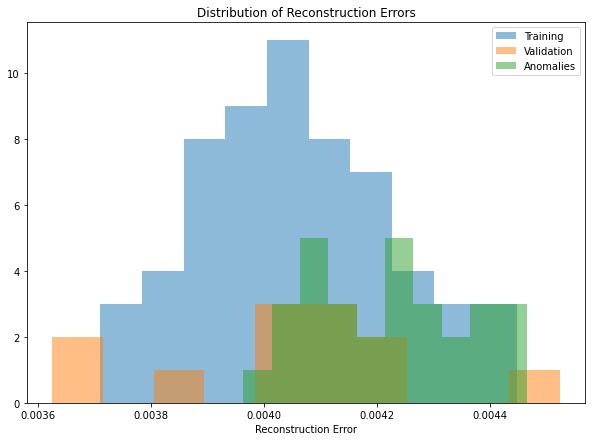

In [331]:
# Plotting the reconstruction error distributions of the training (normal), validation (normal) and anomalous images
# Ideally we want to see high separation between the normal and anomalous classes
plt.figure(figsize = (10,7))
plt.title('Distribution of Reconstruction Errors')
plt.hist(train_reconstruction_error, alpha=0.5, label='Training')
plt.hist(val_reconstruction_error, alpha=0.5, label='Validation')
plt.hist(anom_reconstruction_error, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Reconstruction Error')

plt.show()

## Verifying distribution of kernel density of anomalous data
Ideally the kernel density of anomalous data should be lower then the kernel density of normal data and below the chosen threshold of 5630.

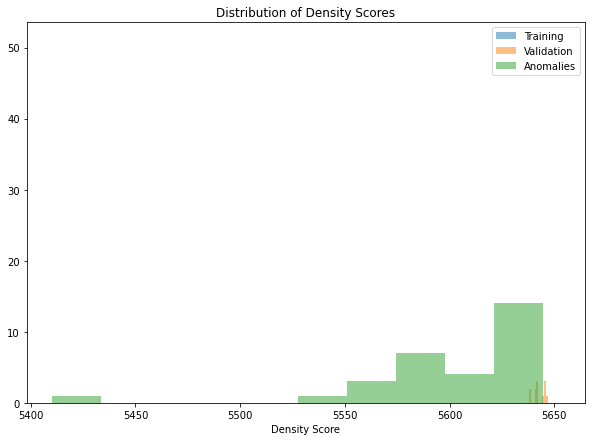

In [335]:
anom_encoded = encoder_replica.predict_generator(anomaly_generator)
anom_enc_flat = [np.reshape(img, (8192)) for img in anom_encoded]
anomaly_density_scores = kde.score_samples(anom_enc_flat)

# Kernel Density Estimation of the encoded vectors
kde = KernelDensity(kernel='gaussian', bandwidth=0.2).fit(encoded_images_flat)
training_density_scores = kde.score_samples(encoded_images_flat) 
validation_density_scores = kde.score_samples(val_enc_flat)

# Plotting the density distributions of the training, validation and anomalous data
plt.figure(figsize = (10,7))
plt.title('Distribution of Density Scores')
plt.hist(training_density_scores, alpha=0.5, label='Training')
plt.hist(validation_density_scores, alpha=0.5, label='Validation')
plt.hist(anomaly_density_scores, alpha=0.5, label='Anomalies')
plt.legend(loc='upper right')
plt.xlabel('Density Score')

plt.show()